# Predykcja czasu dostawy zamówienia


## Wczytanie danych z plików

In [1]:
#installs pandasql within jupyter kernel
%pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import time
import pandas as pd
from pandasql import sqldf

In [3]:
deliveriesFile = open("IUM21L_Zad_03_02/deliveries.jsonl", "r")
productsFile = open("IUM21L_Zad_03_02/products.jsonl", "r")
sessionsFile = open("IUM21L_Zad_03_02/sessions.jsonl", "r")
usersFile = open("IUM21L_Zad_03_02/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

print(deliveries[0].keys())
print(products[0].keys())
print(sessions[0].keys())
print(users[0].keys())

dict_keys(['purchase_id', 'purchase_timestamp', 'delivery_timestamp', 'delivery_company'])
dict_keys(['product_id', 'product_name', 'category_path', 'price'])
dict_keys(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id'])
dict_keys(['user_id', 'name', 'city', 'street'])


In [4]:
deliveriesDF = pd.DataFrame.from_dict(deliveries)
productsDF = pd.DataFrame.from_dict(products)
sessionsDF = pd.DataFrame.from_dict(sessions)
usersDF = pd.DataFrame.from_dict(users)

In [5]:
pysqldf = lambda q: sqldf(q, globals())
dataDF = pysqldf("SELECT * FROM sessionsDF s JOIN deliveriesDF d ON s.purchase_id = d.purchase_id JOIN productsDF p ON s.product_id = p.product_id JOIN usersDF u ON s.user_id = u.user_id;")
projectedDataDF = pysqldf("SELECT purchase_timestamp, delivery_timestamp, delivery_company, offered_discount, product_name, price, category_path, name, city, street FROM dataDF;")

In [6]:
pysqldf("SELECT * FROM projectedDataDF LIMIT 0;")

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street


In [7]:
#pysqldf("SELECT COUNT(*) FROM dataDF WHERE event_type = \"VIEW_PRODUCT\";")
#pysqldf("SELECT name, city, street, COUNT(*) count FROM projectedDataDF WHERE purchase_timestamp > delivery_timestamp GROUP BY name;")
pysqldf("SELECT count(*) FROM projectedDataDF WHERE purchase_timestamp > delivery_timestamp;")

,count(*)
0,1963


## Wykorzystywane funkcje

In [8]:
# Convert date to unix timestamp (seconds only)
def dateToTimestamp(date):
    date = date.split('.')[0]
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()
    return time.mktime(date)

def timestampToDate(timestamp):
    return datetime.fromtimestamp(timestamp).strftime("%Y-%m-%dT%H:%M:%S")

## Analiza danych

### Ceny produktów

Niektóre ceny są błędne - ujemne lub bardzo duże

In [9]:
products.sort(key=lambda product : product["price"])
print("Price \t Product")
for product in products:
    print(str(product["price"])+"\t"+product["product_name"])

Price 	 Product
-142.99	Race Driver Grid (PC)
-121.9	The Darkness 2 (PC)
-112.28	Sencor SDA-500
-109.0	Fight Night Champion (PS3)
-79.9	Assassin&#39;s Creed 3 (PS3)
-69.99	Sencor SDA-600
-49.99	Assassin&#39;s Creed 3 (Xbox 360)
-39.0	Sniper Ghost Warrior 2 (Xbox 360)
-37.9	Bioshock 2 (PC)
-32.99	Call of Duty Black Ops 2 (PC)
-19.99	Symulator Agrar 2012 (PC)
-19.99	Space Hack (PC)
-14.9	Sniper Ghost Warrior (PC)
-11.9	Street Racing Syndicate (PC)
-9.99	King&#39;s Bounty Nowe Światy (PC)
-1.0	Król Futbolu Piłkarski Quiz (PC)
1.0	Heroes Over Europe (PC)
1.0	The Ball (PC)
1.99	Street Fighter 4 (PC)
3.0	Dragonshard (PC)
3.59	Hearts of Iron 2 (PC)
4.9	Dream Pinball 3D (PC)
4.99	Cities in Motion (PC)
4.99	A New Beginning (PC)
4.99	Rig&#39;n&#39;Roll Tirowiec (PC)
4.99	Symulator Kamieniołomu (PC)
5.0	Symulator Zamiatarki ulic (PC)
7.9	Warhammer 40.000 Space Marine (PC)
8.9	Singularity (PC)
8.99	MAJESTY ANTOLOGIA (PC)
8.99	Euro Truck Simulator (PC)
9.99	Bus Driver (PC)
9.99	Hard Reset (PC)
9.99

### Analiza czasu dostawy

In [72]:
N_SECONDS = 3600.0

correctDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE purchase_timestamp < delivery_timestamp")

#create columns
correctDataDF["purchase_timestamp_sec"] = 0
correctDataDF["delivery_timestamp_sec"] = 0
correctDataDF["delivery_time_h"] = 0.0
correctDataDF["purchase_day_name"] = ""
correctDataDF["delivery_day_name"] = ""

for index, _ in correctDataDF.iterrows():
    correctDataDF.at[index, "purchase_timestamp_sec"] = dateToTimestamp(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp_sec"] = dateToTimestamp(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_time_h"] = float(correctDataDF["delivery_timestamp_sec"].iloc[index] - correctDataDF["purchase_timestamp_sec"].iloc[index]) / N_SECONDS
    correctDataDF.at[index, "purchase_timestamp"] = pd.to_datetime(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp"] = pd.to_datetime(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "purchase_day_name"] = correctDataDF["purchase_timestamp"].iloc[index].day_name()
    correctDataDF.at[index, "delivery_day_name"] = correctDataDF["delivery_timestamp"].iloc[index].day_name()

correctDataDF

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street,purchase_timestamp_sec,delivery_timestamp_sec,delivery_time_h,purchase_day_name,delivery_day_name
0,2021-03-07 03:52:21,2021-03-08 23:29:47.065546,620.0,15,Kyocera FS-3540MFP,5126.00,Komputery;Drukarki i skanery;Biurowe urządzeni...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615085541,1615242587,43.623889,Sunday,Monday
1,2021-03-08 12:51:20,2021-03-10 08:56:30.356048,620.0,0,Manta DVD064,109.00,Sprzęt RTV;Video;Odtwarzacze DVD,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615204280,1615362990,44.086111,Monday,Wednesday
2,2021-03-07 11:10:10,2021-03-07 15:10:29.594621,360.0,0,Plantronics Voyager Legend,249.00,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615111810,1615126229,4.005278,Sunday,Sunday
3,2021-03-14 11:12:10,2021-03-18 08:56:17.888575,360.0,15,Samsung Galaxy S III GT-i9300,2199.90,Telefony i akcesoria;Telefony komórkowe,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615716730,1616054177,93.735278,Sunday,Thursday
4,2021-02-15 02:50:22,2021-02-15 14:10:14.870034,516.0,5,Hama 44292,44.99,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1613353822,1613394614,11.331111,Monday,Monday
5,2021-03-10 06:03:30,2021-03-13 10:58:59.190819,360.0,5,Sing It High School Musical 3 (PS3),99.99,Gry i konsole;Gry na konsole;Gry PlayStation3,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615352610,1615629539,76.924722,Wednesday,Saturday
6,2021-01-02 11:48:02,2021-01-03 02:48:34.468060,360.0,15,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1609584482,1609638514,15.008889,Saturday,Sunday
7,2021-01-04 04:36:27,2021-01-06 08:00:23.647384,360.0,0,Nokia 3310,207.33,Telefony i akcesoria;Telefony komórkowe,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1609731387,1609916423,51.398889,Monday,Wednesday
8,2021-01-26 06:35:11,2021-01-27 01:09:04.528115,620.0,5,Apple iPad mini 64GB,1816.97,Komputery;Tablety i akcesoria;Tablety,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1611639311,1611706144,18.564722,Tuesday,Wednesday
9,2021-03-15 04:44:40,2021-03-18 15:18:31.221571,360.0,15,Call of Duty Black Ops (PC),29.99,Gry i konsole;Gry komputerowe,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615779880,1616077111,82.564167,Monday,Thursday


In [81]:
pysqldf("SELECT city, AVG(delivery_time_h) FROM correctDataDF GROUP BY city ORDER BY AVG(delivery_time_h);")

,city,AVG(delivery_time_h)
0,Warszawa,47.592224
1,Police,47.874228
2,Konin,48.601555
3,Szczecin,48.620962
4,Radom,48.956674
5,Mielec,49.028544
6,Gdynia,50.004451
7,Kutno,50.410385


Jak widać, czas dostawy nie zależy zbytnio od miasta, w którym znajduje się klient. Być może oznacza to, że firma ma oddziały we wszystkich tych miastach.

In [80]:
pysqldf("SELECT purchase_day_name, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY purchase_day_name ORDER BY AVG(delivery_time_h);")

,purchase_day_name,COUNT(*),AVG(delivery_time_h)
0,Monday,652,47.799079
1,Saturday,684,48.120035
2,Wednesday,596,48.471003
3,Thursday,643,48.943231
4,Tuesday,614,49.371340
5,Friday,661,49.492935
6,Sunday,745,49.653701


Czas dostawy nie zależy też od dnia tygodnia, w którym dokonano zakupu.

In [77]:
pysqldf("SELECT delivery_day_name, COUNT(*) FROM correctDataDF GROUP BY delivery_day_name ORDER BY COUNT(*);")

,delivery_day_name,COUNT(*)
0,Thursday,622
1,Saturday,627
2,Friday,648
3,Wednesday,662
4,Sunday,667
5,Monday,676
6,Tuesday,693


Nasi kurierzy działają równie sprawnie w weekendy jak i w pozostałe dni tygodnia.

In [88]:
pysqldf("SELECT category_path, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY category_path ORDER BY AVG(delivery_time_h);")

,category_path,COUNT(*),AVG(delivery_time_h)
0,Sprzęt RTV;Video;Odtwarzacze DVD,295,43.177488
1,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,313,45.001198
2,Komputery;Drukarki i skanery;Biurowe urządzeni...,332,45.213013
3,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,326,47.860112
4,Komputery;Tablety i akcesoria;Tablety,290,48.054924
5,Gry i konsole;Gry na konsole;Gry Xbox 360,286,48.939038
6,Sprzęt RTV;Audio;Słuchawki,332,49.004354
7,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,307,49.442234
8,Telefony i akcesoria;Telefony komórkowe,314,49.564618
9,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,312,50.284382


Widać pewną zależność między kategorią produktu a czasem dostawy, jednak nie jest ona bardzo wyraźna.

In [89]:
pysqldf("SELECT delivery_company, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY delivery_company ORDER BY AVG(delivery_time_h);")

,delivery_company,COUNT(*),AVG(delivery_time_h)
0,620.0,1454,47.238538
1,NaN,218,48.555042
2,360.0,1462,49.116755
3,516.0,1461,50.226304


Z powyższej analizy wynika, że wybór firmy kurierskiej nie wpływa znacznie na czas dostawy.

In [90]:
pysqldf("SELECT offered_discount, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY offered_discount ORDER BY AVG(delivery_time_h);")

,offered_discount,COUNT(*),AVG(delivery_time_h)
0,5,439,47.309820
1,10,485,48.388797
2,15,503,48.513149
3,20,506,48.754345
4,0,2662,49.267382


Oferowana zniżka też w żaden wyraźny sposób nie wpływa na czas dostawy.

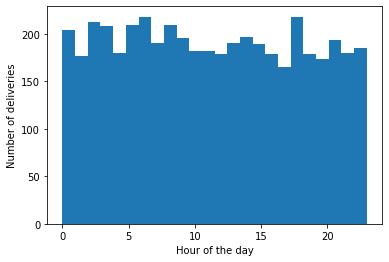

In [100]:
delivery_hours = []

for index, _ in correctDataDF.iterrows():
    delivery_hours.append(correctDataDF["delivery_timestamp"].iloc[index].hour)

plt.hist(delivery_hours, bins=24, density=False)
plt.xlabel("Hour of the day")
plt.ylabel("Number of deliveries")
plt.show()

Firmy kurierskie pracują przez całą dobę.

382 purchases not delivered
7258 purchases delivered


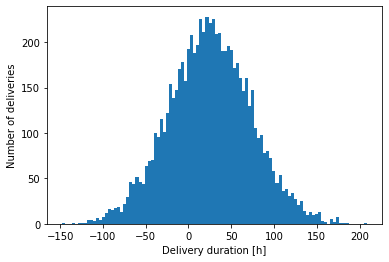

In [10]:
notDeliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is None]
deliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is not None]
print(str(len(notDeliveredList))+" purchases not delivered")
print(str(len(deliveredList))+" purchases delivered")

deliveryTimes = [dateToTimestamp(delivery['delivery_timestamp']) for delivery in deliveredList]
purchaseTimes = [dateToTimestamp(delivery['purchase_timestamp']) for delivery in deliveredList]

deliveryDurations = [(deliveryTime - purchaseTime)/3600 for deliveryTime, purchaseTime in zip(deliveryTimes, purchaseTimes)]

plt.hist(deliveryDurations, density=False, bins=100)
plt.ylabel('Number of deliveries')
plt.xlabel('Delivery duration [h]')
plt.show()

Company 620
2321 deliveries


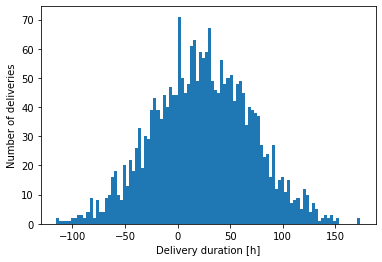

Company None
337 deliveries


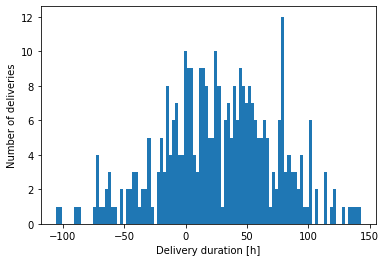

Company 516
2305 deliveries


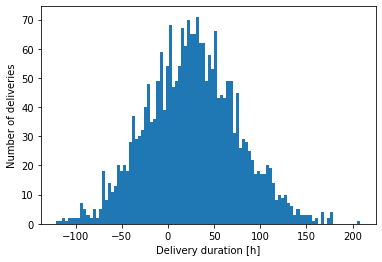

Company 360
2295 deliveries


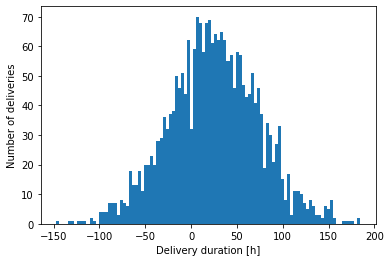

In [11]:
companies = []
for delivery in deliveries:
    if delivery['delivery_company'] not in companies:# and delivery['delivery_company'] is not None:
        companies.append(delivery['delivery_company'])

for company in companies:
    print('Company '+str(company))
    durations = []
    counter = 0
    for delivery in deliveredList:
        if delivery['delivery_company'] == company:
            counter += 1
            durations.append((dateToTimestamp(delivery['delivery_timestamp']) - dateToTimestamp(delivery['purchase_timestamp']))/3600)
    print(str(counter)+' deliveries')
    plt.hist(durations, density=False, bins=100)
    plt.ylabel('Number of deliveries')
    plt.xlabel('Delivery duration [h]')
    plt.show()